In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.cluster
from xgboost import XGBRegressor

import shap
from numba import njit

seed = 2023
np.random.seed(seed)

In [9]:
X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

This is the partition explainer example data. It is relatively small so I will use this for development and figuring out if my approach works.

I will first figure out how to create masks consistent with an arbitrary hierarchy. 

Lets say: 

HouseCharacteristics <- [AveRooms, AveBedrms, AveOccup, HouseAge]  but there can be more than 2 merges at the bottom

Location <- [Latitude, Longitude]

Neighbours <- [MedInc, Population]

Area <- [Location, Neighbours]

Top <- [HouseCharacteristics, Area]

Essentially we want to specify such hierarchy *but the tree is non-binary*

I think the best idea is to specify a hierarchy (non-binary tree) convert

In [18]:
hierarchy = {
    'Top': ['HouseCharacteristics', 'Area'],
    'HouseCharacteristics': ['AveRooms', 'AveBedrms', 'AveOccup', 'HouseAge'],
    'Area': ['Location', 'Neighbours'],
    'Location': ['Latitude', 'Longitude'],
    'Neighbours': ['MedInc', 'Population']
}

Probably the best way to deal with this is via a dictionary as the scipy array will restrict users to binary trees no matter what does mean we will have to verify the dictionary validity



VALID partition_tree:
    - each node is represented only once 
    - each key is present only once 

## This is what the partition tree explainer uses scipy hierarchical clustering

In [10]:
def partition_tree(X, metric="correlation"):
    X_full_rank = X + np.random.randn(*X.shape) * 1e-8
    D = scipy.spatial.distance.pdist(
        X_full_rank.fillna(X_full_rank.mean()).T, metric=metric
    )
    return scipy.cluster.hierarchy.complete(D)

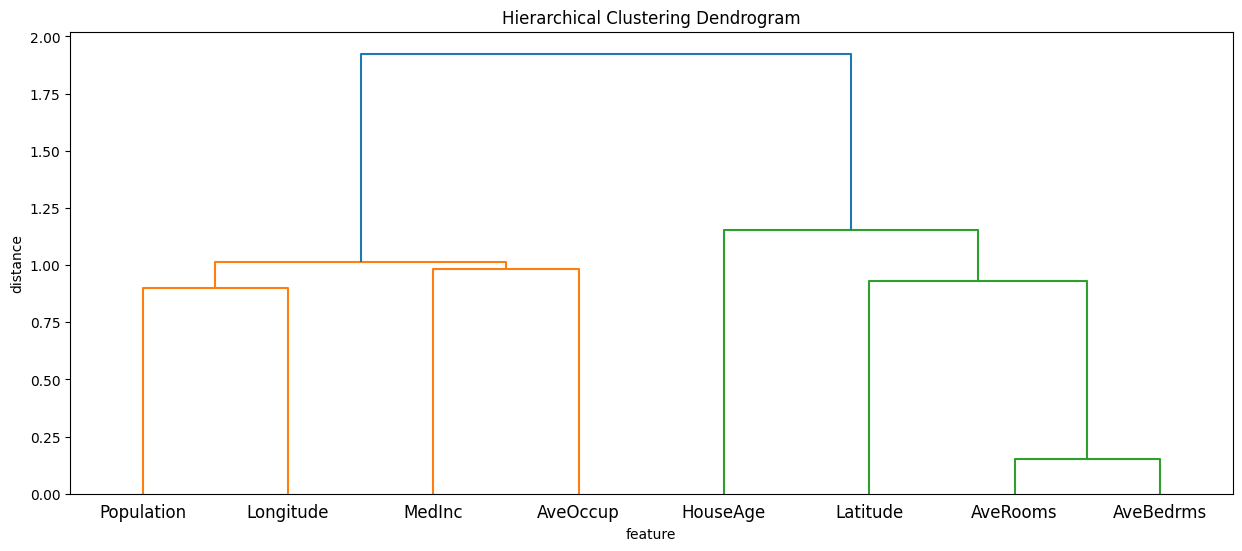

In [11]:
partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

In [12]:
partition_tree

array([[ 2.        ,  3.        ,  0.15237867,  2.        ],
       [ 4.        ,  7.        ,  0.90022678,  2.        ],
       [ 6.        ,  8.        ,  0.93027887,  3.        ],
       [ 0.        ,  5.        ,  0.98123375,  2.        ],
       [ 9.        , 11.        ,  1.01517587,  4.        ],
       [ 1.        , 10.        ,  1.15327742,  4.        ],
       [12.        , 13.        ,  1.92466443,  8.        ]])

# Reworking the make_masks function here

In [15]:
def make_masks(cluster_matrix):
    """Builds a sparse CSR mask matrix from the given clustering.

    This function is optimized since trees for images can be very large.
    """
    M = cluster_matrix.shape[0] + 1  # the number of binary clusters plus one
    indices_row_pos = np.zeros(2 * M - 1, dtype=int)
    indptr = np.zeros(2 * M, dtype=int)
    indices = np.zeros(int(np.sum(cluster_matrix[:, 3])) + M, dtype=int)
    #print(M)
    #print(indices_row_pos)
    #print(indptr)
    #print(indices)

    # build an array of index lists in CSR format
    _init_masks(cluster_matrix, M, indices_row_pos, indptr)
    _rec_fill_masks(
        cluster_matrix,
        indices_row_pos,
        indptr,
        indices,
        M,
        cluster_matrix.shape[0] - 1 + M,
    )
    mask_matrix = scipy.sparse.csr_matrix(
        (np.ones(len(indices), dtype=bool), indices, indptr), shape=(2 * M - 1, M)
    )

    return mask_matrix


@njit
def _init_masks(cluster_matrix, M, indices_row_pos, indptr):
    pos = 0
    for i in range(2 * M - 1):  # loop throught the length of the binary tree *
        if i < M:
            pos += 1
        else:
            pos += int(cluster_matrix[i - M, 3])
        #print(pos)
        indptr[i + 1] = pos
        indices_row_pos[i] = indptr[i]


@njit
def _rec_fill_masks(cluster_matrix, indices_row_pos, indptr, indices, M, ind):
    pos = indices_row_pos[ind]

    if ind < M:
        indices[pos] = ind
        return

    lind = int(cluster_matrix[ind - M, 0])
    rind = int(cluster_matrix[ind - M, 1])
    lind_size = int(cluster_matrix[lind - M, 3]) if lind >= M else 1
    rind_size = int(cluster_matrix[rind - M, 3]) if rind >= M else 1

    lpos = indices_row_pos[lind]
    rpos = indices_row_pos[rind]

    _rec_fill_masks(cluster_matrix, indices_row_pos, indptr, indices, M, lind)
    indices[pos : pos + lind_size] = indices[lpos : lpos + lind_size]

    _rec_fill_masks(cluster_matrix, indices_row_pos, indptr, indices, M, rind)
    indices[pos + lind_size : pos + lind_size + rind_size] = indices[
        rpos : rpos + rind_size
    ]

In [17]:
make_masks(partition_tree).toarray()

array([[ True, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False],
       [False, False, False, False,  True, False, False, False],
       [False, False, False, False, False,  True, False, False],
       [False, False, False, False, False, False,  True, False],
       [False, False, False, False, False, False, False,  True],
       [False, False,  True,  True, False, False, False, False],
       [False, False, False, False,  True, False, False,  True],
       [False, False,  True,  True, False, False,  True, False],
       [ True, False, False, False, False,  True, False, False],
       [ True, False, False, False,  True,  True, False,  True],
       [False,  True,  True,  True, False, False,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True]])